<a href="https://colab.research.google.com/github/1920039/cuk_vision/blob/main/11_gan_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `11-gan.ipynb`

**모델 및 소스코드 참고**  

David Foster저 Generative Deep Learning (O'REILLY출판, 2019)


# Autoencoder

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)                               # data 폴더를 만들고 그 밑에 weights 폴더도 만듬
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [3]:

MODE =  'build' #'load' #
#MODE =  'load'

**Encoder 모델 정의**

In [4]:
z_dim = 2    # latent vector의 dimension이 작아서 좋은 결과를 얻기 어렵지만, latent vector의 분포를 시각화하여 보기 편하기 때문에 2차원 사용

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)           # LeakyReLU 다음에 ()를 쓰고 다시 (x)를 씀에 유의
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)     # strides=2이니 크기가 1/2로 줄어듬
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]      # K.int_shape은 shape을 튜플로 반환함...참고로 K.shape은 텐서로 반환
                                                  # [1:]이라고 썼으니, x.shape = (None, 7, 7, 64)에서 두번째 것부터 사용하여 (7, 7, 64)가 됨
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)      # Dense의 노드 수를 z_dim으로 맞춤
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

디코더 모델 만들기

In [5]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')    # 앞서 z_dim = 2로 정해준 것은 그냥 숫자가 아니라 차원(dim)으로 쓰려는 목적였음
x = Dense(np.prod(shape_before_flattening))(decoder_input)      # np.prod는 element들의 곱. 여기서는 7 x 7 x 64가 됨
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)    # Conv2DTranspose에서 strides=1이므로 일반 conv와 동일함
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)     # (None, 28, 28, 32) --> (None, 28, 28, 1) : 노드가 1개니 shape의 마지막 값이 1로 바뀜(흑백 이미지)
                                                                                           # 컬러 이미지라면 3을 써서 원래의 이미지에 가깝게 복원할 수 있을까? (있을 듯)     
decoder_output = Activation('sigmoid')(x)          # image를 0~1 사이로 normalize하는 걸 표준으로 삼았기 때문에, 그걸 그대로 사용
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [6]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0   

In [7]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):    # **kwargs는 a = b 형식으로 인자를 받아서 딕셔너리를 생성('key word argu.'). 여기서는 실제 사용하지는 않음
        super(AutoEncoder, self).__init__(**kwargs)    # 의미? super().__init__(변수명)은 부모 class의 __init()__에서 정의된 변수를 재사용하는 것인데, super() 안에 AutoEncoder를 쓰는 것은 왜?
                                                       # super 괄호 안에 아무 것도 안 써도 잘 실행됨
                                                       # super(Class명, self).__init__(~~)은 파이썬 2.7에서 사용하던 문법인데, 그 흔적이 남아서 많은 코드들에서 여전히 사용되고 있음.
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):              # 이 class가 호출되었을 때 어떻게 동작하는지를 알려주는 부분
        latent = self.encoder(inputs)      # inputs --> latent
        return self.decoder(latent)        # latent --> outputs   # 앞에서 encoder, decoder를 각각 따로 만들었는데, 여기서 연결관계를 형성함

@tf.function     # 아래의 셀 설명 참조
def r_loss(y_true, y_pred):         # reconstruction loss
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])   # MSE. axis 1,2,3 각각에 대해 mean ( = reduce_mean과 다른가?)????????????????????????

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [8]:
# @는 장식자(decorator)로서 그 다음에 오는 함수를 감싸주면서(=wrapper의 일종) 새로운 기능도 추가
# 여기서 '새로운 기능'이라 함은 tf.function의 기능임.

# 참고로 wrapper에는 decorator도 있고, adapter도 있음
# 아래의 '@tf.function' 부분을
# 장식자를 사용하지 않고 그 다음에 오는 함수를 바로 인자로 넣어서 다음과 같이 쓸 수도 있음
# tf.function(compute_loss_and_grads(~~~))

# tf.function() 함수는 그 다음에 오는 compute_loss_and_grads() 함수를 인자로 받아서 Autograph라는 기능을 추가
# Autograph는 파이썬 문법으로서, 그래프(Graph)를 컨트롤할 수 있게 해줌. 
# 보다 구체적으로 설명하면,
# 여기서는 GradientTape이 계산에 관계되는 모든 변수와 연산을 추적하기 때문에 performance에 영향을 주는데,
# tf.function 장식자를 붙이면 이 연산들을 고성능의 그래프 연산으로 변환하기 때문에 performance를 개선할 수 있음
# 통상 파이썬 코드가 실행 시 계산됨에 비해 그래프 연산은 사전 컴파일되어 실행 속도가 빨라짐.

In [9]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)   # 객체 생성
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=r_loss)    # 위에서 만든 AutoEncoder(흔히 쓰는 'model'에 해당)와 r_loss를 여기서 합쳐서 컴파일함

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)     # 중간중간에 저장해 둠. 속도가 빨라서 굳이 필요하지 않음
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

INFO:tensorflow:Assets written to: data/weights/assets


INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [13]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)   # 저장된 파일이 보이지 않음. save_weights_only=False라서?

#callbacks_list = [checkpoint]
callbacks_list = []      
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)   # 세 번만 실행하였음
ae.save(save_folder)

Epoch 1/200
32/32 [==============================] - 4s 112ms/step - loss: 0.0539
Epoch 2/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0532
Epoch 3/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0527
Epoch 4/200
32/32 [==============================] - 4s 110ms/step - loss: 0.0525
Epoch 5/200
32/32 [==============================] - 4s 110ms/step - loss: 0.0519
Epoch 6/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0514
Epoch 7/200
32/32 [==============================] - 4s 109ms/step - loss: 0.0512
Epoch 8/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0510
Epoch 9/200
32/32 [==============================] - 4s 110ms/step - loss: 0.0505
Epoch 10/200
32/32 [==============================] - 4s 110ms/step - loss: 0.0502
Epoch 11/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0498
Epoch 12/200
32/32 [==============================] - 4s 112ms/step - loss: 0.0495
Epoch 13/200


INFO:tensorflow:Assets written to: data/weights/assets


**모델 읽어들이기**

In [14]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


**생성해 보기**

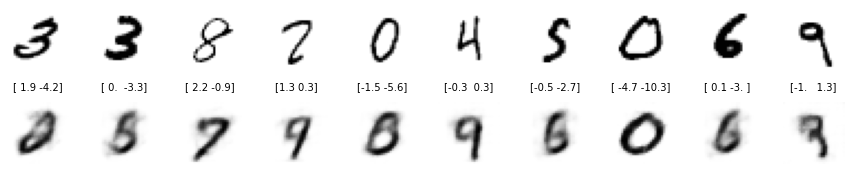

In [15]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)     # 저장해 두었던 모델을 불러와서 encode하고
reconst_images = ae.decoder.predict(z_points)     # 학습시켰던 모델로 decode함. 왜?

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

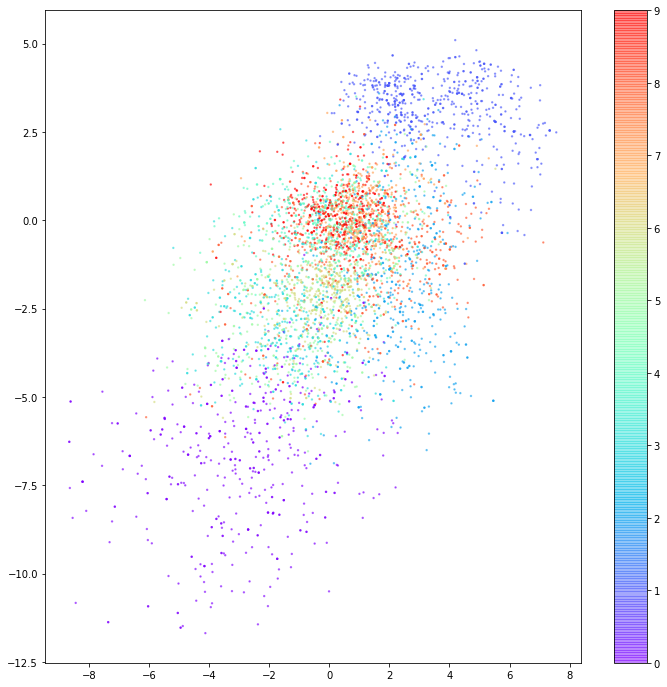

In [16]:
# x_test 샘플 5000개를 encoder에 넣어서 어떤 z 값으로 vector화하는지를 가시화
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)     

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

**Latent space에서 일정 간격으로 latent vector를 추출하여 생성된 결과**

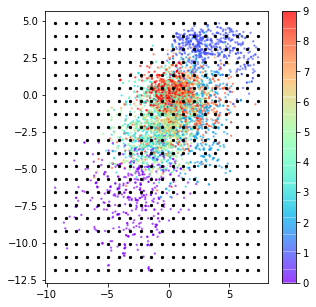

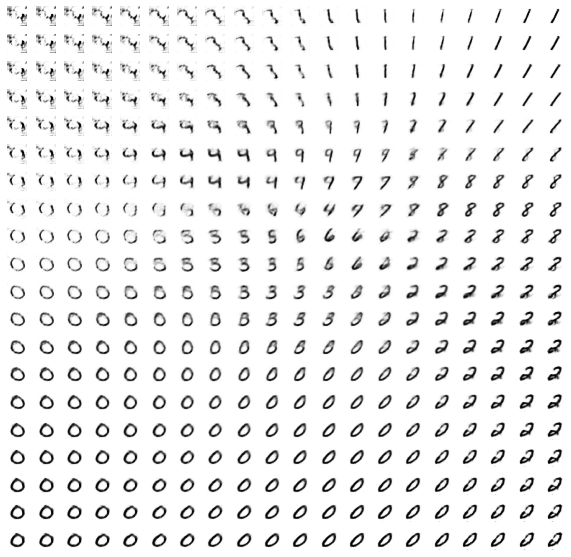

In [17]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)    # x.shape --> (20,) 즉 ([1,2,3,4,....20])의 모양새
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()          # xv.shape --> (400,) 
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)        # z_grid의 모든 좌표값을 decoder에 넣어서 예측값을 구했음

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')    # reconst.shape --> (400, 28, 28, 1)

# GAN

In [ ]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy


Downloading...
From: https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
To: /content/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
100% 133M/133M [00:01<00:00, 93.6MB/s]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

**Quick! Draw! database**  
Dataset 홈페이지:  https://quickdraw.withgoogle.com/data  
Motorbike numpy 다운로드: https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/motorbike.npy  

Quick & Draw 참여 페이지  
https://quickdraw.withgoogle.com/  


In [ ]:
# 넘파이를 읽어 들여서 안에 있는 이미지 데이터를 추출: 요즘엔 많이 쓰이지 않고 이 용도로만 쓰임

SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [ ]:
x_train, y_train = load_quickdraw('motorbike')

In [ ]:
# (28, 28, 1)의 오토바이 이미지 8만개(x_train)를 준비하고, 그 중에서 batch size(64)만큼씩의 이미지를 매 epoch마다 꺼내와서 학습(=train_on_batch).   
# 따라서 8만개의 x_train 데이터셋이 모두 epoch수만큼 학습되는 기존의 CNN 학습 방법과 다름  
# 왜 train_on_batch를 쓸까? 다양한 샘플로 학습시키되 epoch(=weights 갱신)은 바꾸어줌으로써 학습시간이 너무 오래 걸리지 않게 하는 효과가 있을 듯
# 매 epoch마다 generator, discriminator가 한번씩 학습하는데, epoch(batch) 마다 다른 데이터를 사용함에도 학습의 진전은 이루어짐
# 코드 끝부분에서 batch별 loss, accuracy를 비교하는 것은 사실 서로 다른 데이터 샘플을 사용한 batch들 간의 비교임. 그럼에도 전반적인 추세는 보임

print(len(x_train), x_train[0].shape)
print(len(y_train), y_train[0])    # y_train의 값은 모두 다 0이다. y_train 값은 사용하지 않을 듯. discriminator가 뭐라고 판별하는지가 기준이 됨

80000 (28, 28, 1)
80000 0


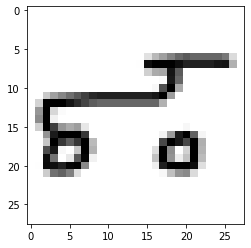

In [ ]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

입력 이미지 사이즈: (28,28)

In [ ]:
input_dim = (28,28,1)
# weights들이 너무 튀지 않도록 하기 위해 weights initialization (여기서는 정의만, 나중에 conv에서 사용)
weight_init = RandomNormal(mean=0., stddev=0.02)   

**Discriminator 모델 정의**

In [ ]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)    # kernel initializer의 평균, 표준편차 값을 지정해 주기 위해서 미리 weight_init이라는 객체(?) 생성
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',      # 참, 거짓 둘 중 하나만 출력하면 됨
    kernel_initializer = weight_init)(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 re_lu_8 (ReLU)              (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                     

**Generator 모델 정의**

In [ ]:
z_dim = 100      # 보통 100 이상 사용함. 클수록 더 그럴듯한 이미지를 생성

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = weight_init)(generator_input)   # (7, 7, 64)는 위 discriminator에서 거쳐왔던 크기 중 하나를 선택했음
x = BatchNormalization(momentum=0.9)(x)       # normalize를 할 때 momentum을 줌. SGD에서 momentum을 주었던 것과 동일 ????????????????????????????????????????????
x = ReLU()(x)
x = Reshape((7,7,64))(x)
# autoencoder의 decoder에서는 Conv2DTranspose를 썼는데, 여기서는 UpSampling2D를 쓰면서 conv2D를 같이 썼음. 심지어는 아래에서는 다시 Conv2DTranspose(strides=1이라 일반 conv인 셈이지만)를 썼음
# Conv2DTranspose 또는 UpSampling2D + Conv2D는 학습을 하지만, UpSampling2D만을 사용하면 학습을 하지 않음
x = UpSampling2D()(x)        
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
# "Conv2DTranspose이지만 strides=1이므로 일반 conv와 동일함" 
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x)    #### tanh니까 출력은 -1 ~ 1 나옴. 따라서 img normalize도 -1 ~ 1로 해야 함
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_4 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 re_lu_12 (ReLU)             (None, 3136)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 64)       0 

Discriminator를 먼저 컴파일

In [ ]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Discriminator를 freeze하고, generator와 연결하여  
model을 정의  
Generator용 모델 컴파일  

In [ ]:
### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val            ## discriminator의 경우를 예로 들면, discriminator 전체를 먼저 False로 만들고,
    for l in m.layers:
        l.trainable = val        ## discriminator 내 각각의 layer들도 추가로 False로 만들었음

# 먼저 discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))    # model_input는 z(100 dim). 이것을 generator에 먼저 넣고, 그 다음 discriminator에 넣음
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(learning_rate=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

최초 실행시에는 `build`를 사용  
저장된 weights를 loading해서 계속할 때에는 `load`사용

In [ ]:
mode = 'build'
#mode = 'load' (저장한 것을 불러올 때 사용)

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

INFO:tensorflow:Assets written to: gan_data/assets


d,g의 loss 및 accuracy를 저장해 두는 변수

In [ ]:
total_epoch = 0
d_losses = []
g_losses = []

**GAN 학습**

In [ ]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))   # 표준정규분포. 평균 0, 표준편차 1
    gen_imgs = generator.predict(noise)                   # discriminator 학습 함수인데, generator에서 이미지를 만들어 내고 그걸 사용하는 부분이 포함되어 있음(당연)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)   # true_imgs에는 1을 줌.       train_on_batch는 fit 대비 학습시킬 데이터를 원하는 부분만 골라서 넣을 수 있게 함
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)     # gen_imgs에는 0을 줌
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))     # generator는 결과가 1이 나오도록 노력
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)              # discriminator 학습에서는 discriminator를 학습시켰지만, 여기서는 generator가 아닌 model을 학습시킴. 
                                                           # 밑에서 보면 이 둘은 번갈아 가며 학습하게 됨
                                                           # model.train_on_batch는 위 discriminator 경우를 참고하면, loss와 accuracy를 return함
                                                           # 여기서의 loss는, 위에서 '전체 GAN을 compile'할 때, model에 binary_cross_entropy를 loss로 주었으니, 그것을 사용함

# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        # 매 epoch에서 discriminator와 generator를 번갈아 가면서 학습시킴
        d = train_discriminator(x_train, batch_size)      
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [ ]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 200

train(            # 앞서 정의한 함수임. 학습에 10분 정도 소요됨
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

252 [D loss: (0.595)(R 0.500, F 0.691)] [D acc: (0.688)(0.766, 0.609)] [G loss: 0.736] [G acc: 0.406]
253 [D loss: (0.658)(R 0.456, F 0.859)] [D acc: (0.602)(0.812, 0.391)] [G loss: 0.744] [G acc: 0.078]
254 [D loss: (0.583)(R 0.507, F 0.660)] [D acc: (0.750)(0.625, 0.875)] [G loss: 0.784] [G acc: 0.094]
255 [D loss: (0.710)(R 0.307, F 1.113)] [D acc: (0.703)(0.938, 0.469)] [G loss: 0.721] [G acc: 0.219]
256 [D loss: (0.740)(R 0.483, F 0.996)] [D acc: (0.477)(0.797, 0.156)] [G loss: 0.796] [G acc: 0.156]
257 [D loss: (0.655)(R 0.612, F 0.698)] [D acc: (0.672)(0.734, 0.609)] [G loss: 0.706] [G acc: 0.375]
258 [D loss: (0.733)(R 0.575, F 0.891)] [D acc: (0.445)(0.688, 0.203)] [G loss: 0.714] [G acc: 0.375]
259 [D loss: (0.697)(R 0.592, F 0.801)] [D acc: (0.477)(0.656, 0.297)] [G loss: 0.740] [G acc: 0.250]
260 [D loss: (0.680)(R 0.624, F 0.736)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.763] [G acc: 0.234]
261 [D loss: (0.685)(R 0.626, F 0.743)] [D acc: (0.516)(0.578, 0.453)] [G loss: 0.

**학습 epoch에 따른 d,g의 loss및 accuracy 변화 그래프**

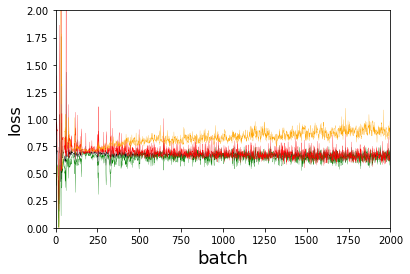

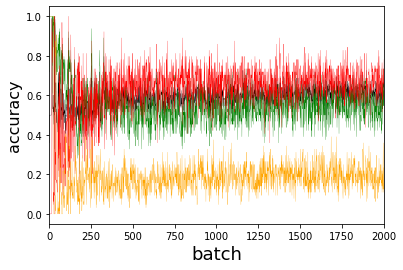

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

최종 학습된 결과를 random gaussian noise를 이용하여 생성

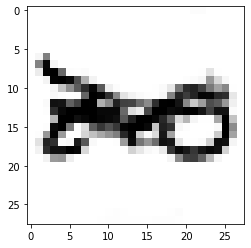

In [ ]:
import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()

epoch 20 생성 샘플

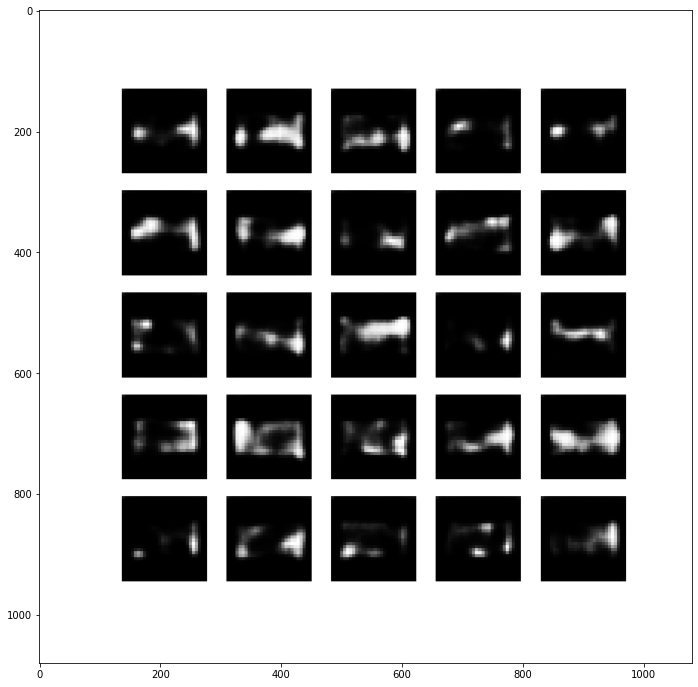

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 100 생성 샘플

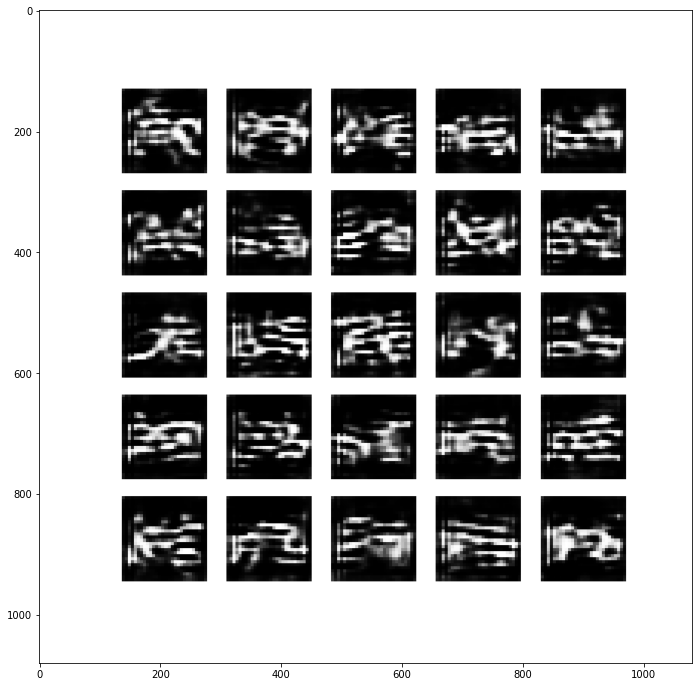

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 200 생성 샘플

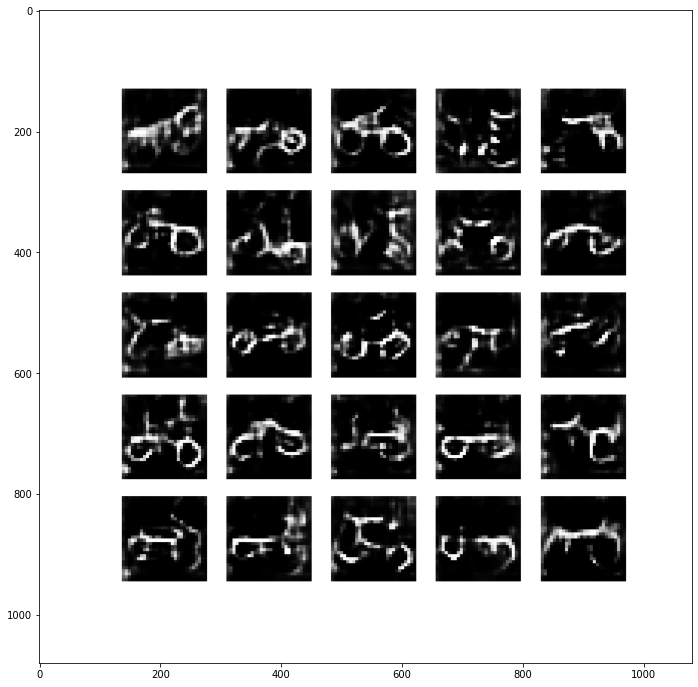

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 2000 생성 샘플

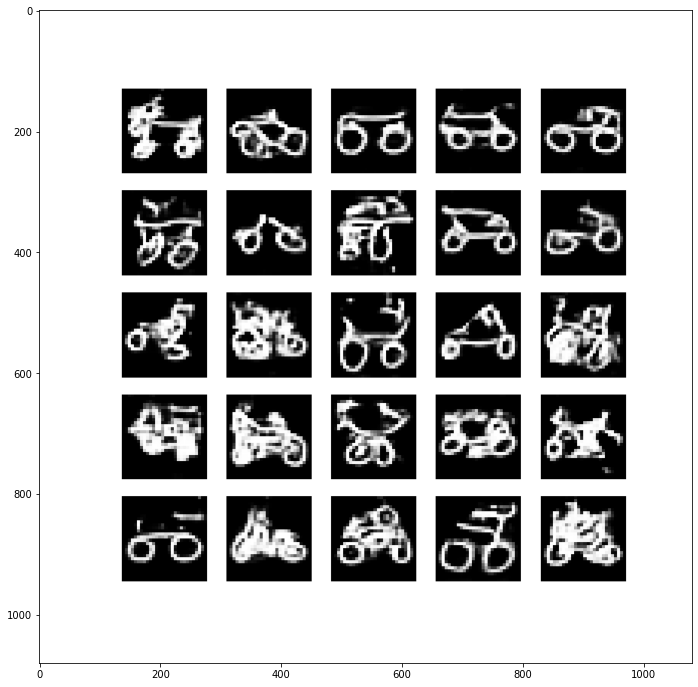

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 2000)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()